# Lab 4: The Multi-Layer Perceptron
## by Michael Doherty, Leilani Guzman, and Carson Pittman

Our goal is to predict what the child poverty rate for each county in the United States will be.

Link to the dataset: https://www.kaggle.com/datasets/muonneutrino/us-census-demographic-data/data

## 1. Load, Split, and Balance
### 1.1 Loading the Data

To begin, we need to load in the data and store it in a Pandas dataframe.

In [2]:
import pandas as pd

df = pd.read_csv("data/acs2017_census_tract_data.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74001 entries, 0 to 74000
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TractId           74001 non-null  int64  
 1   State             74001 non-null  object 
 2   County            74001 non-null  object 
 3   TotalPop          74001 non-null  int64  
 4   Men               74001 non-null  int64  
 5   Women             74001 non-null  int64  
 6   Hispanic          73305 non-null  float64
 7   White             73305 non-null  float64
 8   Black             73305 non-null  float64
 9   Native            73305 non-null  float64
 10  Asian             73305 non-null  float64
 11  Pacific           73305 non-null  float64
 12  VotingAgeCitizen  74001 non-null  int64  
 13  Income            72885 non-null  float64
 14  IncomeErr         72885 non-null  float64
 15  IncomePerCap      73256 non-null  float64
 16  IncomePerCapErr   73256 non-null  float6

As shown above, there are several missing datapoints in the dataset; seeing as the dataset is so large, we will remove the observations that have missing data.

We also need to change the <code>State</code> and <code>County</code> attributes from strings to numeric data so we can use them in our neural network. For now, we will simply encode them as integers by mapping each string to an integer (such as mapping 'Alabama' to 1, 'Alaska' to 2, etc.).

In [3]:
# remove rows with missing data
df.dropna(inplace=True)

# Drop tract column
df.drop(columns=['TractId'], inplace=True)
df.drop(columns=['County'], inplace=True)

# convert 'State' strings to integers
unique_states = df['State'].unique()

state_to_int = { }

counter = 1

for state in unique_states:
    state_to_int[state] = counter
    counter += 1

# 'Alabama' = 1, 'Alaska' = 2, 'Arizona' = 3, etc.
df['State'] = df['State'].map(state_to_int)

# # convert 'County' strings to integers
# unique_counties = df['County'].unique()

# county_to_int = { }

# counter = 1

# for county in unique_counties:
#     county_to_int[county] = counter
#     counter += 1
    
# # 'Autauga County' = 1, 'Baldwin County' = 2, 'Barbour County' = 3, etc.
# df['County'] = df['County'].map(county_to_int)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 72718 entries, 0 to 74000
Data columns (total 35 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   State             72718 non-null  int64  
 1   TotalPop          72718 non-null  int64  
 2   Men               72718 non-null  int64  
 3   Women             72718 non-null  int64  
 4   Hispanic          72718 non-null  float64
 5   White             72718 non-null  float64
 6   Black             72718 non-null  float64
 7   Native            72718 non-null  float64
 8   Asian             72718 non-null  float64
 9   Pacific           72718 non-null  float64
 10  VotingAgeCitizen  72718 non-null  int64  
 11  Income            72718 non-null  float64
 12  IncomeErr         72718 non-null  float64
 13  IncomePerCap      72718 non-null  float64
 14  IncomePerCapErr   72718 non-null  float64
 15  Poverty           72718 non-null  float64
 16  ChildPoverty      72718 non-null  float64
 17

,State,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1,1845,899,946,2.4,86.3,5.2,0.0,1.2,0.0,...,0.5,0.0,2.1,24.5,881,74.2,21.2,4.5,0.0,4.6
1,1,2172,1167,1005,1.1,41.6,54.5,0.0,1.0,0.0,...,0.0,0.5,0.0,22.2,852,75.9,15.0,9.0,0.0,3.4
2,1,3385,1533,1852,8.0,61.4,26.5,0.6,0.7,0.4,...,1.0,0.8,1.5,23.1,1482,73.3,21.1,4.8,0.7,4.7
3,1,4267,2001,2266,9.6,80.3,7.1,0.5,0.2,0.0,...,1.5,2.9,2.1,25.9,1849,75.8,19.7,4.5,0.0,6.1
4,1,9965,5054,4911,0.9,77.5,16.4,0.0,3.1,0.0,...,0.8,0.3,0.7,21.0,4787,71.4,24.1,4.5,0.0,2.3


We decided to keep the <code>County</code> variable instead of removing it. While the <code>State</code> variable gives us enough information to geographically represent each part of the country, we believe that the <code>County</code> variable allows us to break these geographic locations down even further (which we think is important, as it is often the case that different parts of a state have vast differences in the makeup of their population, especially in large states like Texas). Since we are predicting the child poverty rate for each county, we believe that being able to distinguish statistical features between counties is important. Thus, we will keep the <code>County</code> variable.

### 1.2 Splitting the Dataset

Now we need to split the dataset into training data and testing data. We'll use 80% of the data for training and 20% of the data for testing. It's important that we do this before balancing the dataset, as we only want to balance the training data; this is because the testing data should be a representative sample of the population, meaning it shouldn't necessarily be balanced (as a truly random sample of the population likely wouldn't be balanced either). We want our model to be able to correctly predict the <code>ChildPoverty</code> for any sample of data, regardless of if the data is balanced or not. Thus, we will split the dataset before only balancing the training data.

In [4]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["ChildPoverty"])
y = df["ChildPoverty"]

# 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### 1.3 Balancing the Dataset

Now that we have split our dataset into testing and training data, we need to balance the testing dataset; to do that, we'll split the data into four classes based on the quartiles for <code>ChildPoverty</code>.

In [5]:
import numpy as np

quartile_cutoffs = y_train.quantile([0.25, 0.5, 0.75])

quartiles = []

for val in y_train:
    if val < quartile_cutoffs[0.25]:
        quartiles.append(1) # Quartile 1
    elif val < quartile_cutoffs[0.5]:
        quartiles.append(2) # Quartile 2
    elif val < quartile_cutoffs[0.75]:
        quartiles.append(3) # Quartile 3
    else:
        quartiles.append(4) # Quartile 4
        
        
print('Quartile 1 count:', quartiles.count(1))
print('Quartile 2 count:', quartiles.count(2))
print('Quartile 3 count:', quartiles.count(3))
print('Quartile 4 count:', quartiles.count(4))
        
# X_train['ChildPovertyClass'] = quartiles
y_train = quartiles
y_train = np.array(y_train)

quartiles_test = []

for val in y_test:
    if val < quartile_cutoffs[0.25]:
        quartiles_test.append(1) # Quartile 1
    elif val < quartile_cutoffs[0.5]:
        quartiles_test.append(2) # Quartile 2
    elif val < quartile_cutoffs[0.75]:
        quartiles_test.append(3) # Quartile 3
    else:
        quartiles_test.append(4) # Quartile 4

# X_test['ChildPovertyClass'] = quartiles_test
y_test = quartiles_test
y_test = np.array(y_test)

Quartile 1 count: 14450
Quartile 2 count: 14593
Quartile 3 count: 14554
Quartile 4 count: 14577


As shown above, by splitting the training data into quartiles (based off the values of <code>ChildPoverty</code> in <code>y_train</code>), we have about the same number of instances in each of the four classes. We believe this is the best method to balance the data, as it groups together instances that have similiar <code>ChildPoverty</code> values. **ADD MORE??**

## 2. Pre-Processing and Initial Modeling
### 2.1 Two-Layer Perceptron

In [6]:
from scipy.special import expit
import sys
import pandas as pd

# Example from class

class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None, minibatches=1):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.minibatches = int(minibatches)
        
    @staticmethod
    def _encode_labels(y):
        onehot = pd.get_dummies(y).values.T
        return onehot

    def _initialize_weights(self):
        """Initialize weights using Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_))
        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden)) 
        
        b1 = np.zeros((self.n_hidden, 1))
        b2 = np.zeros((self.n_output_, 1))
        
        return W1, W2, b1, b2

    
    @staticmethod
    def _sigmoid(z):
        return expit(z)
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        # Compute L2-regularization cost
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        # Updated for cross entropy
        #Get the objective function value
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3)+(1-Y_enc)*np.log(1-A3))))
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term

In [7]:
from sklearn.metrics import accuracy_score

class TwoLayerPerceptron(TwoLayerPerceptronBase):
    def _feedforward(self, X, W1, W2, b1, b2):
        # Compute feedforward step
        # X : Input layer with original features.
        # W1: Weight matrix for input layer -> hidden layer.
        # W2: Weight matrix for hidden layer -> output layer.
        # a1-a3 : activations into layer (or output layer)
        # z1-z2 : layer inputs

        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2) 
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        # Compute gradient step using backpropagation
        # vectorized backpropagation
        V2 = (A3-Y_enc) # Updated for cross entropy
        V1 = A2*(1-A2)*(W2.T @ V2)
    
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C * 2
        gradW2 += W2 * self.l2_C * 2 

        return gradW1, gradW2, gradb1, gradb2
        
    
    def predict(self, X):
        # Predict class labels
        _, _, _, _, A3 = self._feedforward(X,self.W1,self.W2, self.b1, self.b2)
        y_pred = self.unique_[np.argmax(A3, axis=0)]
        return y_pred
    
    
    def fit(self, X, y, print_progress=False):
        self.unique_ = np.unique(y) # Get the unique labels
        # Learn weights from training data
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
       
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.b1, self.b2= self._initialize_weights()
       
        num_samples = X_data.shape[0]
       
        self.cost_ = []
        for i in range(self.epochs):

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            ridx = np.random.permutation(y_data.shape[0])
            X_data, Y_enc = X_data[ridx], Y_enc[:, ridx]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:
                # feedforward all instances
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2, 
                                                       self.b1, 
                                                       self.b2)
           
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost)

                # compute gradient via backpropagation
                gradW1, gradW2, gradb1, gradb2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, Y_enc=Y_enc[:,idx],
                                                W1=self.W1, W2=self.W2)


                self.W1 -= self.eta * gradW1
                self.W2 -= self.eta * gradW2
                self.b1 -= self.eta * gradb1
                self.b2 -= self.eta * gradb2

            self.cost_.append(mini_cost)

        return self

In [8]:
from sklearn.metrics import accuracy_score
import warnings
warnings.simplefilter('ignore')
%matplotlib inline 

# Convert to numpy array
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
X_test_np = np.array(X_test)
y_test_np = np.array(y_test)

neural_network = TwoLayerPerceptron(n_hidden=64,
                                    C=0.1, # tradeoff L2 regularizer
                                    epochs=50, # iterations
                                    eta=0.001,  # learning rate
                                    random_state=1,
                                    minibatches=64)



neural_network.fit(X_train_np, y_train_np, print_progress=5)
yhat = neural_network.predict(X_test_np)

# For Testing
print('Predicted', yhat[:10])
print("Actual", y_test_np[:10])
print('Unique predicted values:', np.unique(yhat))

print('Accuracy:', accuracy_score(y_test_np,yhat))

Epoch: 50/50

Predicted [2 2 2 2 2 2 2 2 2 2]
Actual [3 4 3 4 3 3 4 2 3 2]
Unique predicted values: [2 4]
Accuracy: 0.24944994499449946


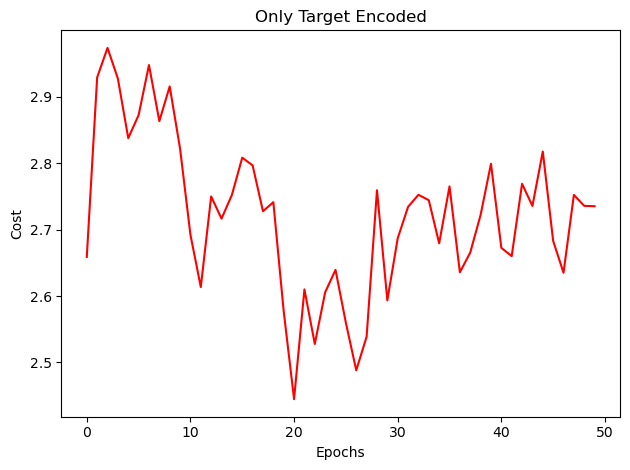

In [9]:
from matplotlib import pyplot as plt

cost_avgs = [np.mean(x) for x in neural_network.cost_]

plt.plot(range(len(cost_avgs)), cost_avgs, color='red')
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.title('Only Target Encoded')
plt.tight_layout()
plt.show()

### 2.2 Normalizing Continuous Numeric Data

In [10]:
# Normalize the continuous features except for state and county
from sklearn import preprocessing

X_train_norm = X_train.copy()
X_test_norm = X_test.copy()

# Normalize without removing state from the dataframe (ignore columns 1)
X_train_norm.iloc[:, 1:] = preprocessing.scale(X_train_norm.iloc[:, 1:])
X_test_norm.iloc[:, 1:] = preprocessing.scale(X_test_norm.iloc[:, 1:])

# Convert to numpy array
X_train_norm_np = np.array(X_train_norm)
X_test_norm_np  = np.array(X_test_norm)

neural_network_2 = TwoLayerPerceptron(n_hidden=64,
                                    C=0.1, # tradeoff L2 regularizer
                                    epochs=50, # iterations
                                    eta=0.001,  # learning rate
                                    random_state=1,
                                    minibatches=64)

neural_network_2.fit(X_train_norm_np, y_train_np, print_progress=5)
yhat_2 = neural_network_2.predict(X_test_norm_np)

print('Accuracy:', accuracy_score(y_test_np, yhat_2))

Epoch: 50/50

Accuracy: 0.5831958195819582


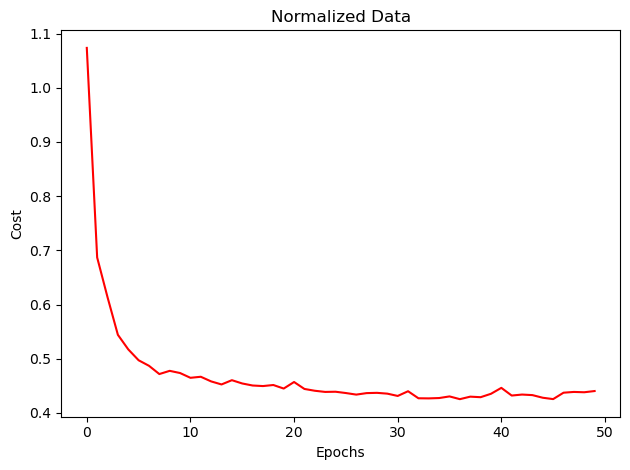

In [11]:
cost_avgs = [np.mean(x) for x in neural_network_2.cost_]

plt.plot(range(len(cost_avgs)), cost_avgs, color='red')
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.title('Normalized Data')
plt.tight_layout()
plt.show()

### 2.3 One Hot Encoding Categorical Data

In [12]:
# One hot encode the state and county columns and normalize the continuous features, but keep the state and county columns in the final result
from sklearn import preprocessing

 
# One hot encode the state and county columns

combined_data = pd.concat([X_train_norm, X_test_norm], axis=0)
combined_data_encoded = pd.get_dummies(combined_data, columns=['State'], dtype=int)
X_train_norm = combined_data_encoded[:len(X_train_norm)]
X_test_norm = combined_data_encoded[len(X_train_norm):]


# Convert to numpy array
# This is the final processed data that is normalized and one hot encoded

X_train_norm_np = np.array(X_train_norm)
X_test_norm_np = np.array(X_test_norm)


In [13]:
neural_network_3 = TwoLayerPerceptron(n_hidden=64,
                                    C=0.1, # tradeoff L2 regularizer
                                    epochs=50, # iterations
                                    eta=0.001,  # learning rate
                                    random_state=1,
                                    minibatches=64)

neural_network_3.fit(X_train_norm_np, y_train_np, print_progress=5)
yhat_3 = neural_network_3.predict(X_test_norm_np)

print('Accuracy:', accuracy_score(y_test_np, yhat_3))

Epoch: 50/50

Accuracy: 0.733567106710671


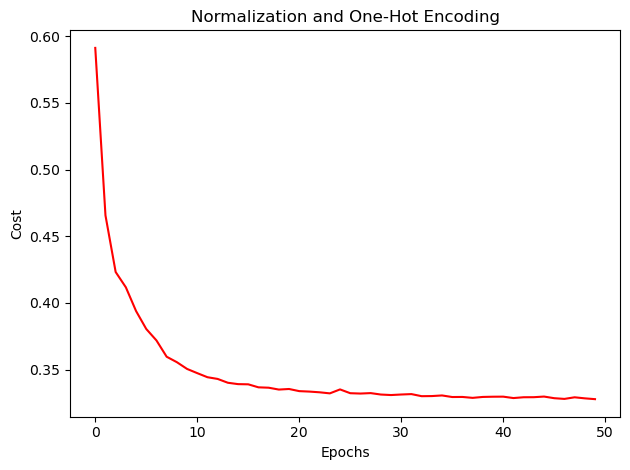

In [14]:
cost_avgs = [np.mean(x) for x in neural_network_3.cost_]

plt.plot(range(len(cost_avgs)), cost_avgs, color='red')
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.title('Normalization and One-Hot Encoding')
plt.tight_layout()
plt.show()

### 2.4 Comparison

## 3. Modeling
### 3.1 Adding a Third Layer

In [15]:
class ThreeLayerPerceptron(TwoLayerPerceptron):
    def __init__(self, n_hidden_1=30, n_hidden_2=30,
             C=0.0, epochs=500, eta=0.001, random_state=None, minibatches=1):
        np.random.seed(random_state)
        self.n_hidden_1 = n_hidden_1
        self.n_hidden_2 = n_hidden_2
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.minibatches = int(minibatches)
        
    def _initialize_weights(self):
        """Initialize weights using Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden_1 + self.n_features_))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden_1, self.n_features_))

        init_bound = 4*np.sqrt(6 / (self.n_hidden_2 + self.n_hidden_1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_hidden_2, self.n_hidden_1))
        
        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden_2))
        W3 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden_2)) 
        
        b1 = np.zeros((self.n_hidden_1, 1))
        b2 = np.zeros((self.n_hidden_2, 1))
        b3 = np.zeros((self.n_output_, 1))
        
        return W1, W2, W3, b1, b2, b3

    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3):
        # Compute L2-regularization cost
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2) + np.mean(W3[:, 1:] ** 2)) 
    
    def _cost(self,A4,Y_enc,W1,W2,W3):
        # Updated for cross entropy
        # Get the objective function value
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A4)+(1-Y_enc)*np.log(1-A4))))
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3)
        return cost + L2_term
    
    def _feedforward1(self, X, W1, W2, W3, b1, b2, b3):
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        Z3 = W3 @ A3 + b3
        A4 = self._sigmoid(Z3)
        return A1, Z1, A2, Z2, A3, Z3, A4
    
    def _get_gradient(self, A1, A2, A3, A4, Z1, Z2, Z3, Y_enc, W1, W2, W3):
        # Compute gradient step using backpropagation
        # vectorized backpropagation
        
        V3 = (A4-Y_enc)
        V2 = A3*(1-A3)*(W3.T @ V3)
        V1 = A2*(1-A2)*(W2.T @ V2)
    
        gradW3 = V3 @ A3.T
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T
        gradb3 = np.sum(V3, axis=1).reshape((-1,1))
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        # regularize weights that are not bias terms
        gradW3 += W3 * self.l2_C * 2 
        gradW2 += W2 * self.l2_C * 2 
        gradW1 += W1 * self.l2_C * 2
        
        return gradW1, gradW2, gradW3, gradb1, gradb2, gradb3
    
    def predict(self, X):
        # Predict class labels
        _, _, _, _, _, _, A4 = self._feedforward1(X,self.W1,self.W2,self.W3,self.b1,self.b2,self.b3)
        y_pred = self.unique_[np.argmax(A4, axis=0)]
        return y_pred
    
    def fit(self, X, y, print_progress=False):
        self.unique_ = np.unique(y) # Get the unique labels
        # Learn weights from training data
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
       
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.b1, self.b2, self.b3 = self._initialize_weights()
       
        num_samples = X_data.shape[0]
       
        # Track the gradient values
        self.grad_w1_ = np.zeros(self.epochs)
        self.grad_w2_ = np.zeros(self.epochs)
        self.grad_w3_ = np.zeros(self.epochs)
    
        self.cost_ = []
        for i in range(self.epochs):

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            ridx = np.random.permutation(y_data.shape[0])
            X_data, Y_enc = X_data[ridx], Y_enc[:, ridx]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:
                # feedforward all instances
                A1, Z1, A2, Z2, A3, Z3, A4 = self._feedforward1(X_data[idx],
                                                               self.W1,
                                                               self.W2,
                                                               self.W3,
                                                               self.b1, 
                                                               self.b2,
                                                               self.b3)
           
                cost = self._cost(A4,Y_enc[:, idx],self.W1,self.W2,self.W3)
                mini_cost.append(cost)

                # compute gradient via backpropagation
                gradW1, gradW2, gradW3, gradb1, gradb2, gradb3 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, 
                                                                 Z1=Z1, Z2=Z2, Z3=Z3, Y_enc=Y_enc[:,idx],
                                                                 W1=self.W1, W2=self.W2, W3=self.W3)
                
                self.grad_w1_[i] = np.mean(np.abs(gradW1))
                self.grad_w2_[i] = np.mean(np.abs(gradW2))
                self.grad_w3_[i] = np.mean(np.abs(gradW3))

                self.W1 -= self.eta * gradW1
                self.W2 -= self.eta * gradW2
                self.W3 -= self.eta * gradW3
                self.b1 -= self.eta * gradb1
                self.b2 -= self.eta * gradb2
                self.b3 -= self.eta * gradb3

            self.cost_.append(mini_cost)

        return self

In [16]:
neural_network_4 = ThreeLayerPerceptron(n_hidden_1=64,
                                        n_hidden_2=64,
                                        C=0.1, # tradeoff L2 regularizer
                                        epochs=50, # iterations
                                        eta=0.001,  # learning rate
                                        random_state=1,
                                        minibatches=64)

neural_network_4.fit(X_train_norm_np, y_train_np, print_progress=5)
yhat_4 = neural_network_4.predict(X_test_norm_np)

print('Accuracy:', accuracy_score(y_test_np, yhat_4))

Epoch: 50/50

Accuracy: 0.7297167216721672


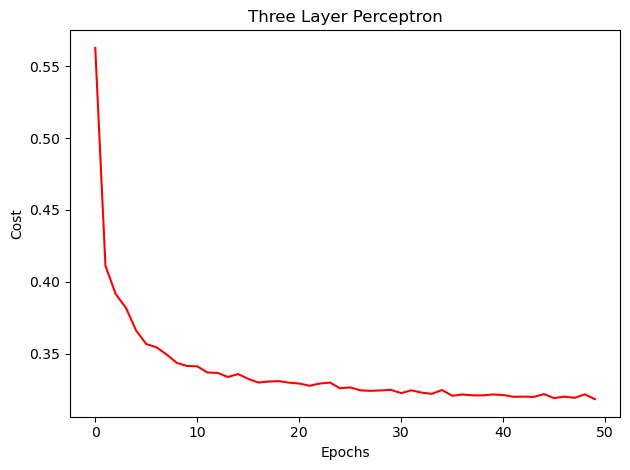

In [17]:
cost_avgs = [np.mean(x) for x in neural_network_4.cost_]

plt.plot(range(len(cost_avgs)), cost_avgs, color='red')
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.title('Three Layer Perceptron')
plt.tight_layout()
plt.show()

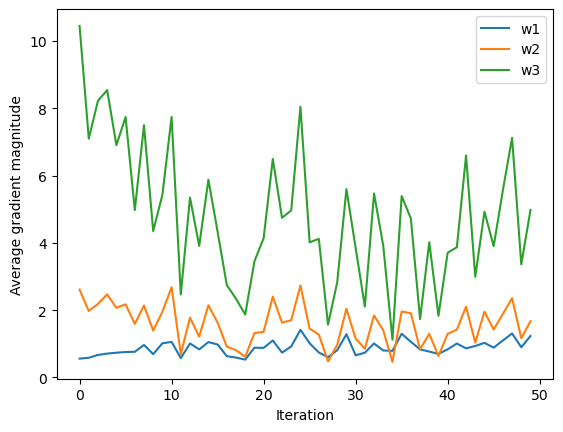

In [18]:
ax = plt.subplot(1,1,1)
plt.plot(np.abs(neural_network_4.grad_w1_), label='w1')
plt.plot(np.abs(neural_network_4.grad_w2_), label='w2')
plt.plot(np.abs(neural_network_4.grad_w3_), label='w3')
plt.legend()
plt.ylabel('Average gradient magnitude')
plt.xlabel('Iteration')
plt.show()

### 3.2 Adding a Fourth Layer

In [19]:
class FourLayerPerceptron(ThreeLayerPerceptron):
    def __init__(self, n_hidden_1=30, n_hidden_2=30, n_hidden_3=30,
             C=0.0, epochs=500, eta=0.001, random_state=None, minibatches=1):
        np.random.seed(random_state)
        self.n_hidden_1 = n_hidden_1
        self.n_hidden_2 = n_hidden_2
        self.n_hidden_3 = n_hidden_3
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.minibatches = int(minibatches)
        
    def _initialize_weights(self):
        """Initialize weights using Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden_1 + self.n_features_))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden_1, self.n_features_))

        init_bound = 4*np.sqrt(6 / (self.n_hidden_2 + self.n_hidden_1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_hidden_2, self.n_hidden_1))
        
        init_bound = 4*np.sqrt(6 / (self.n_hidden_3 + self.n_hidden_2))
        W3 = np.random.uniform(-init_bound, init_bound,(self.n_hidden_3, self.n_hidden_2))
        
        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden_3))
        W4 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden_3)) 
        
        b1 = np.zeros((self.n_hidden_1, 1))
        b2 = np.zeros((self.n_hidden_2, 1))
        b3 = np.zeros((self.n_hidden_3, 1))
        b4 = np.zeros((self.n_output_, 1))
        
        return W1, W2, W3, W4, b1, b2, b3, b4

    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3, W4):
        # Compute L2-regularization cost
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2) + np.mean(W3[:, 1:] ** 2) + np.mean(W4[:, 1:] ** 2)) 
    
    def _cost(self,A5,Y_enc,W1,W2,W3,W4):
        # Updated for cross entropy
        # Get the objective function value
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A5)+(1-Y_enc)*np.log(1-A5))))
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3, W4)
        return cost + L2_term
    
    def _feedforward1(self, X, W1, W2, W3, W4, b1, b2, b3, b4):
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        Z3 = W3 @ A3 + b3
        A4 = self._sigmoid(Z3)
        Z4 = W4 @ A4 + b4
        A5 = self._sigmoid(Z4)
        return A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5
    
    def _get_gradient(self, A1, A2, A3, A4, A5, Z1, Z2, Z3, Z4, Y_enc, W1, W2, W3, W4):
        # Compute gradient step using backpropagation
        # vectorized backpropagation
        
        V4 = (A5-Y_enc)
        V3 = A4*(1-A4)*(W4.T @ V4)
        V2 = A3*(1-A3)*(W3.T @ V3)
        V1 = A2*(1-A2)*(W2.T @ V2)
    
        gradW4 = V4 @ A4.T
        gradW3 = V3 @ A3.T
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T
        gradb4 = np.sum(V4, axis=1).reshape((-1,1))
        gradb3 = np.sum(V3, axis=1).reshape((-1,1))
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        # regularize weights that are not bias terms
        gradW4 += W4 * self.l2_C * 2
        gradW3 += W3 * self.l2_C * 2 
        gradW2 += W2 * self.l2_C * 2 
        gradW1 += W1 * self.l2_C * 2
        
        return gradW1, gradW2, gradW3, gradW4, gradb1, gradb2, gradb3, gradb4
    
    def predict(self, X):
        # Predict class labels
        _, _, _, _, _, _, _, _, A5 = self._feedforward1(X,self.W1,self.W2,self.W3,self.W4,self.b1,self.b2,self.b3,self.b4)
        y_pred = self.unique_[np.argmax(A5, axis=0)]
        return y_pred
    
    def fit(self, X, y, print_progress=False):
        self.unique_ = np.unique(y) # Get the unique labels
        # Learn weights from training data
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
       
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4 = self._initialize_weights()
       
        num_samples = X_data.shape[0]
       
        # Track the gradient values
        self.grad_w1_ = np.zeros(self.epochs)
        self.grad_w2_ = np.zeros(self.epochs)
        self.grad_w3_ = np.zeros(self.epochs)
        self.grad_w4_ = np.zeros(self.epochs)
    
        self.cost_ = []
        for i in range(self.epochs):

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            ridx = np.random.permutation(y_data.shape[0])
            X_data, Y_enc = X_data[ridx], Y_enc[:, ridx]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:
                # feedforward all instances
                A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5 = self._feedforward1(X_data[idx],
                                                                        self.W1,
                                                                        self.W2,
                                                                        self.W3,
                                                                        self.W4,
                                                                        self.b1, 
                                                                        self.b2,
                                                                        self.b3,
                                                                        self.b4)
           
                cost = self._cost(A5,Y_enc[:, idx],self.W1,self.W2,self.W3,self.W4)
                mini_cost.append(cost)

                # compute gradient via backpropagation
                gradW1, gradW2, gradW3, gradW4, gradb1, gradb2, gradb3, gradb4 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, A5=A5,
                                                                 Z1=Z1, Z2=Z2, Z3=Z3, Z4=Z4, Y_enc=Y_enc[:,idx],
                                                                 W1=self.W1, W2=self.W2, W3=self.W3, W4=self.W4)
                
                self.grad_w1_[i] = np.mean(np.abs(gradW1))
                self.grad_w2_[i] = np.mean(np.abs(gradW2))
                self.grad_w3_[i] = np.mean(np.abs(gradW3))
                self.grad_w4_[i] = np.mean(np.abs(gradW4))

                self.W1 -= self.eta * gradW1
                self.W2 -= self.eta * gradW2
                self.W3 -= self.eta * gradW3
                self.W4 -= self.eta * gradW4
                self.b1 -= self.eta * gradb1
                self.b2 -= self.eta * gradb2
                self.b3 -= self.eta * gradb3
                self.b4 -= self.eta * gradb4

            self.cost_.append(mini_cost)

        return self

In [20]:
neural_network_5 = FourLayerPerceptron(n_hidden_1=64,
                                       n_hidden_2=64,
                                       n_hidden_3=64,
                                       C=0.1, # tradeoff L2 regularizer
                                       epochs=50, # iterations
                                       eta=0.001,  # learning rate
                                       random_state=1,
                                       minibatches=64)

neural_network_5.fit(X_train_norm_np, y_train_np, print_progress=5)
yhat_5 = neural_network_5.predict(X_test_norm_np)

print('Accuracy:', accuracy_score(y_test_np, yhat_5))

Epoch: 50/50

Accuracy: 0.7276540154015402


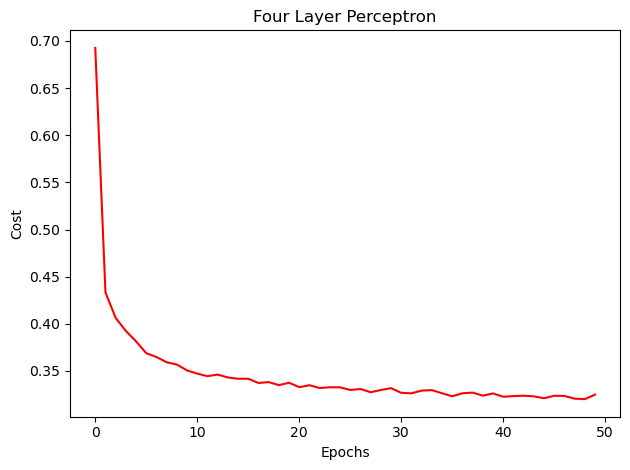

In [21]:
cost_avgs = [np.mean(x) for x in neural_network_5.cost_]

plt.plot(range(len(cost_avgs)), cost_avgs, color='red')
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.title('Four Layer Perceptron')
plt.tight_layout()
plt.show()

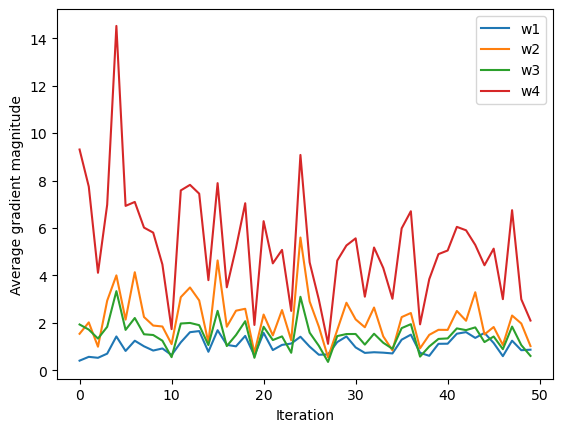

In [22]:
ax = plt.subplot(1,1,1)
plt.plot(np.abs(neural_network_5.grad_w1_), label='w1')
plt.plot(np.abs(neural_network_5.grad_w2_), label='w2')
plt.plot(np.abs(neural_network_5.grad_w3_), label='w3')
plt.plot(np.abs(neural_network_5.grad_w4_), label='w4')
plt.legend()
plt.ylabel('Average gradient magnitude')
plt.xlabel('Iteration')
plt.show()

### 3.3 Adding a Fifth Layer

In [23]:
class FiveLayerPerceptron(FourLayerPerceptron):
    def __init__(self, n_hidden_1=30, n_hidden_2=30, n_hidden_3=30, n_hidden_4=30,
             C=0.0, epochs=500, eta=0.001, random_state=None, minibatches=1):
        np.random.seed(random_state)
        self.n_hidden_1 = n_hidden_1
        self.n_hidden_2 = n_hidden_2
        self.n_hidden_3 = n_hidden_3
        self.n_hidden_4 = n_hidden_4
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.minibatches = int(minibatches)
        
    def _initialize_weights(self):
        """Initialize weights using Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden_1 + self.n_features_))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden_1, self.n_features_))

        init_bound = 4*np.sqrt(6 / (self.n_hidden_2 + self.n_hidden_1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_hidden_2, self.n_hidden_1))
        
        init_bound = 4*np.sqrt(6 / (self.n_hidden_3 + self.n_hidden_2))
        W3 = np.random.uniform(-init_bound, init_bound,(self.n_hidden_3, self.n_hidden_2))
        
        init_bound = 4*np.sqrt(6 / (self.n_hidden_4 + self.n_hidden_3))
        W4 = np.random.uniform(-init_bound, init_bound,(self.n_hidden_4, self.n_hidden_3))
        
        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden_4))
        W5 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden_4)) 
        
        b1 = np.zeros((self.n_hidden_1, 1))
        b2 = np.zeros((self.n_hidden_2, 1))
        b3 = np.zeros((self.n_hidden_3, 1))
        b4 = np.zeros((self.n_hidden_4, 1))
        b5 = np.zeros((self.n_output_, 1))
        
        return W1, W2, W3, W4, W5, b1, b2, b3, b4, b5

    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3, W4, W5):
        # Compute L2-regularization cost
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2) + np.mean(W3[:, 1:] ** 2) + np.mean(W4[:, 1:] ** 2) + np.mean(W5[:, 1:] ** 2)) 
    
    def _cost(self,A6,Y_enc,W1,W2,W3,W4,W5):
        # Updated for cross entropy
        # Get the objective function value
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A6)+(1-Y_enc)*np.log(1-A6))))
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3, W4, W5)
        return cost + L2_term
    
    def _feedforward1(self, X, W1, W2, W3, W4, W5, b1, b2, b3, b4, b5):
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        Z3 = W3 @ A3 + b3
        A4 = self._sigmoid(Z3)
        Z4 = W4 @ A4 + b4
        A5 = self._sigmoid(Z4)
        Z5 = W5 @ A5 + b5
        A6 = self._sigmoid(Z5)
        return A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6
    
    def _get_gradient(self, A1, A2, A3, A4, A5, A6, Z1, Z2, Z3, Z4, Z5, Y_enc, W1, W2, W3, W4, W5):
        # Compute gradient step using backpropagation
        # vectorized backpropagation
        
        V5 = (A6-Y_enc)
        V4 = A5*(1-A5)*(W5.T @ V5)
        V3 = A4*(1-A4)*(W4.T @ V4)
        V2 = A3*(1-A3)*(W3.T @ V3)
        V1 = A2*(1-A2)*(W2.T @ V2)
    
        gradW5 = V5 @ A5.T
        gradW4 = V4 @ A4.T
        gradW3 = V3 @ A3.T
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T
        gradb5 = np.sum(V5, axis=1).reshape((-1,1))
        gradb4 = np.sum(V4, axis=1).reshape((-1,1))
        gradb3 = np.sum(V3, axis=1).reshape((-1,1))
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        # regularize weights that are not bias terms
        gradW5 += W5 * self.l2_C * 2
        gradW4 += W4 * self.l2_C * 2
        gradW3 += W3 * self.l2_C * 2 
        gradW2 += W2 * self.l2_C * 2 
        gradW1 += W1 * self.l2_C * 2
        
        return gradW1, gradW2, gradW3, gradW4, gradW5, gradb1, gradb2, gradb3, gradb4, gradb5
    
    def predict(self, X):
        # Predict class labels
        _, _, _, _, _, _, _, _, _, _, A6 = self._feedforward1(X,self.W1,self.W2,self.W3,self.W4,self.W5,self.b1,self.b2,self.b3,self.b4,self.b5)
        y_pred = self.unique_[np.argmax(A6, axis=0)]
        return y_pred
    
    def fit(self, X, y, print_progress=False):
        self.unique_ = np.unique(y) # Get the unique labels
        # Learn weights from training data
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
       
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.W4, self.W5, self.b1, self.b2, self.b3, self.b4, self.b5 = self._initialize_weights()
       
        num_samples = X_data.shape[0]
       
        # Track the gradient values
        self.grad_w1_ = np.zeros(self.epochs)
        self.grad_w2_ = np.zeros(self.epochs)
        self.grad_w3_ = np.zeros(self.epochs)
        self.grad_w4_ = np.zeros(self.epochs)
        self.grad_w5_ = np.zeros(self.epochs)
    
        self.cost_ = []
        for i in range(self.epochs):

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            ridx = np.random.permutation(y_data.shape[0])
            X_data, Y_enc = X_data[ridx], Y_enc[:, ridx]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:
                # feedforward all instances
                A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6 = self._feedforward1(X_data[idx],
                                                                                self.W1,
                                                                                self.W2,
                                                                                self.W3,
                                                                                self.W4,
                                                                                self.W5,
                                                                                self.b1, 
                                                                                self.b2,
                                                                                self.b3,
                                                                                self.b4,
                                                                                self.b5)
           
                cost = self._cost(A6,Y_enc[:, idx],self.W1,self.W2,self.W3,self.W4,self.W5)
                mini_cost.append(cost)

                # compute gradient via backpropagation
                gradW1, gradW2, gradW3, gradW4, gradW5, gradb1, gradb2, gradb3, gradb4, gradb5 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, A5=A5, A6=A6,
                                                                                                 Z1=Z1, Z2=Z2, Z3=Z3, Z4=Z4, Z5=Z5, Y_enc=Y_enc[:,idx],
                                                                                                 W1=self.W1, W2=self.W2, W3=self.W3, W4=self.W4, W5=self.W5)
                
                self.grad_w1_[i] = np.mean(np.abs(gradW1))
                self.grad_w2_[i] = np.mean(np.abs(gradW2))
                self.grad_w3_[i] = np.mean(np.abs(gradW3))
                self.grad_w4_[i] = np.mean(np.abs(gradW4))
                self.grad_w5_[i] = np.mean(np.abs(gradW5))

                self.W1 -= self.eta * gradW1
                self.W2 -= self.eta * gradW2
                self.W3 -= self.eta * gradW3
                self.W4 -= self.eta * gradW4
                self.W5 -= self.eta * gradW5
                self.b1 -= self.eta * gradb1
                self.b2 -= self.eta * gradb2
                self.b3 -= self.eta * gradb3
                self.b4 -= self.eta * gradb4
                self.b5 -= self.eta * gradb5

            self.cost_.append(mini_cost)

        return self

In [24]:
neural_network_6 = FiveLayerPerceptron(n_hidden_1=64,
                                       n_hidden_2=64,
                                       n_hidden_3=64,
                                       n_hidden_4=64,
                                       C=0.1, # tradeoff L2 regularizer
                                       epochs=50, # iterations
                                       eta=0.001,  # learning rate
                                       random_state=1,
                                       minibatches=64)

neural_network_6.fit(X_train_norm_np, y_train_np, print_progress=5)
yhat_6 = neural_network_6.predict(X_test_norm_np)

print('Accuracy:', accuracy_score(y_test_np, yhat_6))

Epoch: 50/50

Accuracy: 0.7312293729372937


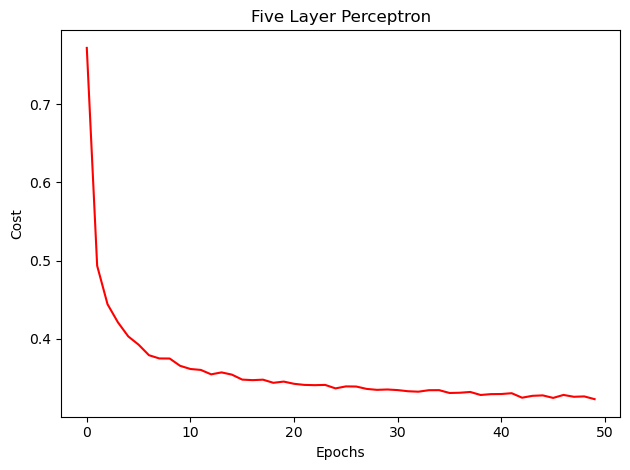

In [25]:
cost_avgs = [np.mean(x) for x in neural_network_6.cost_]

plt.plot(range(len(cost_avgs)), cost_avgs, color='red')
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.title('Five Layer Perceptron')
plt.tight_layout()
plt.show()

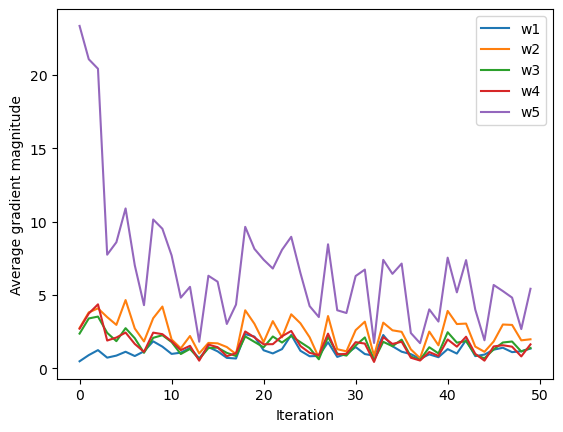

In [26]:
ax = plt.subplot(1,1,1)
plt.plot(np.abs(neural_network_6.grad_w1_), label='w1')
plt.plot(np.abs(neural_network_6.grad_w2_), label='w2')
plt.plot(np.abs(neural_network_6.grad_w3_), label='w3')
plt.plot(np.abs(neural_network_6.grad_w4_), label='w4')
plt.plot(np.abs(neural_network_6.grad_w5_), label='w5')
plt.legend()
plt.ylabel('Average gradient magnitude')
plt.xlabel('Iteration')
plt.show()

### 3.4 Implementing Adaptive Learning RMSProp

In [27]:
class FiveLayerPerceptronRMS(FiveLayerPerceptron):
    def __init__(self, n_hidden_1=30, n_hidden_2=30, n_hidden_3=30, n_hidden_4=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None, minibatches=1, alpha=0.0, 
                 decrease_const=0.1, decrease_iter=10):
        np.random.seed(random_state)
        self.n_hidden_1 = n_hidden_1
        self.n_hidden_2 = n_hidden_2
        self.n_hidden_3 = n_hidden_3
        self.n_hidden_4 = n_hidden_4
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.minibatches = int(minibatches)
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.decrease_iter = decrease_iter
        
    def _initialize_weights(self):
        """Initialize weights using Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden_1 + self.n_features_))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden_1, self.n_features_))

        init_bound = 4*np.sqrt(6 / (self.n_hidden_2 + self.n_hidden_1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_hidden_2, self.n_hidden_1))
        
        init_bound = 4*np.sqrt(6 / (self.n_hidden_3 + self.n_hidden_2))
        W3 = np.random.uniform(-init_bound, init_bound,(self.n_hidden_3, self.n_hidden_2))
        
        init_bound = 4*np.sqrt(6 / (self.n_hidden_4 + self.n_hidden_3))
        W4 = np.random.uniform(-init_bound, init_bound,(self.n_hidden_4, self.n_hidden_3))
        
        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden_4))
        W5 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden_4)) 
        
        b1 = np.zeros((self.n_hidden_1, 1))
        b2 = np.zeros((self.n_hidden_2, 1))
        b3 = np.zeros((self.n_hidden_3, 1))
        b4 = np.zeros((self.n_hidden_4, 1))
        b5 = np.zeros((self.n_output_, 1))
        
        return W1, W2, W3, W4, W5, b1, b2, b3, b4, b5

    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3, W4, W5):
        # Compute L2-regularization cost
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2) + np.mean(W3[:, 1:] ** 2) + np.mean(W4[:, 1:] ** 2) + np.mean(W5[:, 1:] ** 2)) 
    
    def _cost(self,A6,Y_enc,W1,W2,W3,W4,W5):
        # Updated for cross entropy
        # Get the objective function value
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A6)+(1-Y_enc)*np.log(1-A6))))
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3, W4, W5)
        return cost + L2_term
    
    def _feedforward1(self, X, W1, W2, W3, W4, W5, b1, b2, b3, b4, b5):
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        Z3 = W3 @ A3 + b3
        A4 = self._sigmoid(Z3)
        Z4 = W4 @ A4 + b4
        A5 = self._sigmoid(Z4)
        Z5 = W5 @ A5 + b5
        A6 = self._sigmoid(Z5)
        return A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6
    
    def _get_gradient(self, A1, A2, A3, A4, A5, A6, Z1, Z2, Z3, Z4, Z5, Y_enc, W1, W2, W3, W4, W5):
        # Compute gradient step using backpropagation
        # vectorized backpropagation
        
        V5 = (A6-Y_enc)
        V4 = A5*(1-A5)*(W5.T @ V5)
        V3 = A4*(1-A4)*(W4.T @ V4)
        V2 = A3*(1-A3)*(W3.T @ V3)
        V1 = A2*(1-A2)*(W2.T @ V2)
    
        gradW5 = V5 @ A5.T
        gradW4 = V4 @ A4.T
        gradW3 = V3 @ A3.T
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T
        gradb5 = np.sum(V5, axis=1).reshape((-1,1))
        gradb4 = np.sum(V4, axis=1).reshape((-1,1))
        gradb3 = np.sum(V3, axis=1).reshape((-1,1))
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        # regularize weights that are not bias terms
        gradW5 += W5 * self.l2_C * 2
        gradW4 += W4 * self.l2_C * 2
        gradW3 += W3 * self.l2_C * 2 
        gradW2 += W2 * self.l2_C * 2 
        gradW1 += W1 * self.l2_C * 2
        
        return gradW1, gradW2, gradW3, gradW4, gradW5, gradb1, gradb2, gradb3, gradb4, gradb5
    
    def predict(self, X):
        # Predict class labels
        _, _, _, _, _, _, _, _, _, _, A6 = self._feedforward1(X,self.W1,self.W2,self.W3,self.W4,self.W5,self.b1,self.b2,self.b3,self.b4,self.b5)
        y_pred = self.unique_[np.argmax(A6, axis=0)]
        return y_pred
    
    def fit(self, X, y, print_progress=False):
        self.unique_ = np.unique(y) # Get the unique labels
        # Learn weights from training data
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
       
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.W4, self.W5, self.b1, self.b2, self.b3, self.b4, self.b5 = self._initialize_weights()
       
        num_samples = X_data.shape[0]
       
        # Track the gradient values
        self.grad_w1_ = np.zeros(self.epochs)
        self.grad_w2_ = np.zeros(self.epochs)
        self.grad_w3_ = np.zeros(self.epochs)
        self.grad_w4_ = np.zeros(self.epochs)
        self.grad_w5_ = np.zeros(self.epochs)

        # Start momentum at 0 for previous updates
        rho_W1_prev = np.zeros(self.W1.shape) 
        rho_W2_prev = np.zeros(self.W2.shape)
        rho_W3_prev = np.zeros(self.W3.shape)
        rho_W4_prev = np.zeros(self.W4.shape)
        rho_W5_prev = np.zeros(self.W5.shape)

        V1_prev = np.zeros(self.W1.shape)
        V2_prev = np.zeros(self.W2.shape)
        V3_prev = np.zeros(self.W3.shape)
        V4_prev = np.zeros(self.W4.shape)
        V5_prev = np.zeros(self.W5.shape)
    
        self.cost_ = []
        for i in range(self.epochs):
            eta = self.eta * self.decrease_const**(np.floor(i/self.decrease_iter))

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            ridx = np.random.permutation(y_data.shape[0])
            X_data, Y_enc = X_data[ridx], Y_enc[:, ridx]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:
                # feedforward all instances
                A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6 = self._feedforward1(X_data[idx],
                                                                                self.W1,
                                                                                self.W2,
                                                                                self.W3,
                                                                                self.W4,
                                                                                self.W5,
                                                                                self.b1, 
                                                                                self.b2,
                                                                                self.b3,
                                                                                self.b4,
                                                                                self.b5)
           
                cost = self._cost(A6,Y_enc[:, idx],self.W1,self.W2,self.W3,self.W4,self.W5)
                mini_cost.append(cost)

                # compute gradient via backpropagation
                gradW1, gradW2, gradW3, gradW4, gradW5, gradb1, gradb2, gradb3, gradb4, gradb5 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, A5=A5, A6=A6,
                                                                                                 Z1=Z1, Z2=Z2, Z3=Z3, Z4=Z4, Z5=Z5, Y_enc=Y_enc[:,idx],
                                                                                                 W1=self.W1, W2=self.W2, W3=self.W3, W4=self.W4, W5=self.W5)
                
                
                self.grad_w1_[i] = np.mean(np.abs(gradW1))
                self.grad_w2_[i] = np.mean(np.abs(gradW2))
                self.grad_w3_[i] = np.mean(np.abs(gradW3))
                self.grad_w4_[i] = np.mean(np.abs(gradW4))
                self.grad_w5_[i] = np.mean(np.abs(gradW5))

                # momentum and adaptation calculations
                # RMSProp implementation: based on in class examples

                G1, G2, G3, G4, G5 = gradW1 * gradW1, gradW2 * gradW2, gradW3 * gradW3, gradW4 * gradW4, gradW5 * gradW5

                V1 = self.alpha * V1_prev + (1-self.alpha) * G1 + 1e-7
                V2 = self.alpha * V2_prev + (1-self.alpha) * G2 + 1e-7
                V3 = self.alpha * V3_prev + (1-self.alpha) * G3 + 1e-7
                V4 = self.alpha * V4_prev + (1-self.alpha) * G4 + 1e-7
                V5 = self.alpha * V5_prev + (1-self.alpha) * G5 + 1e-7

                # Momentum and RMSProp
                rho_W1 = eta * gradW1 / np.sqrt(V1)
                rho_W2 = eta * gradW2 / np.sqrt(V2)
                rho_W3 = eta * gradW3 / np.sqrt(V3)
                rho_W4 = eta * gradW4 / np.sqrt(V4)
                rho_W5 = eta * gradW5 / np.sqrt(V5)

                self.W1 -= (rho_W1 + self.alpha * rho_W1_prev)  # not sure why it's alpha and not eta
                self.W2 -= (rho_W2 + self.alpha * rho_W2_prev)
                self.W3 -= (rho_W3 + self.alpha * rho_W3_prev)
                self.W4 -= (rho_W4 + self.alpha * rho_W4_prev)
                self.W5 -= (rho_W5 + self.alpha * rho_W5_prev)
                
                self.b1 -= eta * gradb1
                self.b2 -= eta * gradb2
                self.b3 -= eta * gradb3
                self.b4 -= eta * gradb4
                self.b5 -= eta * gradb5

                #Update previous values
                rho_W1_prev, rho_W2_prev, rho_W3_prev, rho_W4_prev, rho_W5_prev = rho_W1, rho_W2, rho_W3, rho_W4, rho_W5
                V1_prev, V2_prev, V3_prev, V4_prev, V5_prev = V1, V2, V3, V4, V5

            self.cost_.append(mini_cost)

        return self

In [28]:
# Adjust parameters to get better results
neural_network_7 = FiveLayerPerceptronRMS(n_hidden_1=64,
                                          n_hidden_2=64,
                                          n_hidden_3=64,
                                          n_hidden_4=64,
                                          C=0.1, # tradeoff L2 regularizer
                                          epochs=50, # iterations
                                          eta=0.001,  # learning rate
                                          random_state=1,
                                          minibatches=64,
                                          alpha=0.5, 
                                          decrease_const=0.1, 
                                          decrease_iter=50)

neural_network_7.fit(X_train_norm_np, y_train_np, print_progress=5)
yhat_7 = neural_network_7.predict(X_test_norm_np)

print('Accuracy:', accuracy_score(y_test_np, yhat_7))

Epoch: 50/50

Accuracy: 0.7356298129812981


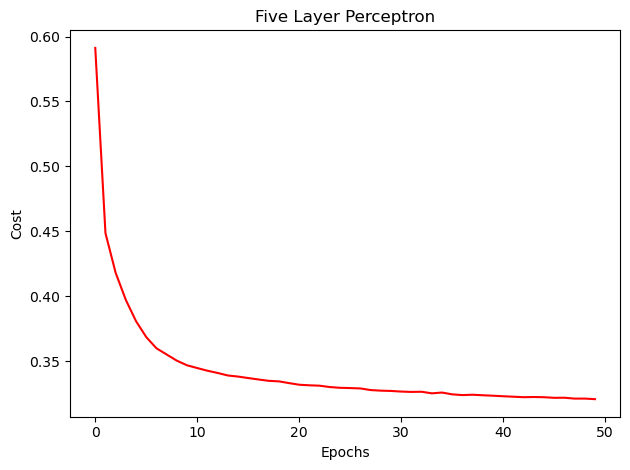

In [29]:
cost_avgs = [np.mean(x) for x in neural_network_7.cost_]

plt.plot(range(len(cost_avgs)), cost_avgs, color='red')
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.title('Five Layer Perceptron')
plt.tight_layout()
plt.show()

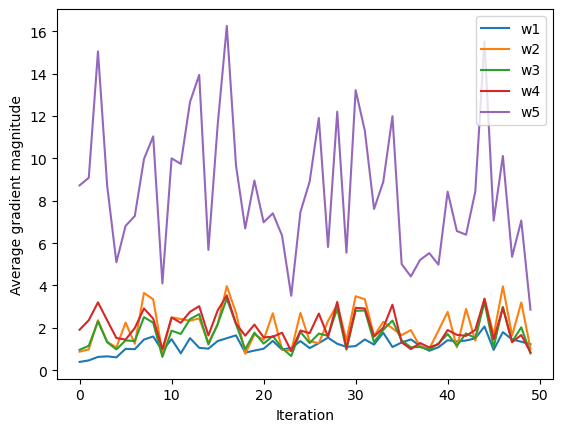

In [30]:
ax = plt.subplot(1,1,1)
plt.plot(np.abs(neural_network_7.grad_w1_), label='w1')
plt.plot(np.abs(neural_network_7.grad_w2_), label='w2')
plt.plot(np.abs(neural_network_7.grad_w3_), label='w3')
plt.plot(np.abs(neural_network_7.grad_w4_), label='w4')
plt.plot(np.abs(neural_network_7.grad_w5_), label='w5')
plt.legend()
plt.ylabel('Average gradient magnitude')
plt.xlabel('Iteration')
plt.show()

## 4. Adaptive Momentum (AdaM)
### 4.1 Implementing Adaptive Momentum

In [55]:
class FiveLayerPerceptronADAM(FiveLayerPerceptron):
    def __init__(self, n_hidden_1=30, n_hidden_2=30, n_hidden_3=30, n_hidden_4=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None, minibatches=1,
                 decrease_const=0.1, decrease_iter=10):
        np.random.seed(random_state)
        self.n_hidden_1 = n_hidden_1
        self.n_hidden_2 = n_hidden_2
        self.n_hidden_3 = n_hidden_3
        self.n_hidden_4 = n_hidden_4
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.minibatches = int(minibatches)
        self.decrease_const = decrease_const
        self.decrease_iter = decrease_iter
        
    def _initialize_weights(self):
        """Initialize weights using Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden_1 + self.n_features_))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden_1, self.n_features_))

        init_bound = 4*np.sqrt(6 / (self.n_hidden_2 + self.n_hidden_1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_hidden_2, self.n_hidden_1))
        
        init_bound = 4*np.sqrt(6 / (self.n_hidden_3 + self.n_hidden_2))
        W3 = np.random.uniform(-init_bound, init_bound,(self.n_hidden_3, self.n_hidden_2))
        
        init_bound = 4*np.sqrt(6 / (self.n_hidden_4 + self.n_hidden_3))
        W4 = np.random.uniform(-init_bound, init_bound,(self.n_hidden_4, self.n_hidden_3))
        
        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden_4))
        W5 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden_4)) 
        
        b1 = np.zeros((self.n_hidden_1, 1))
        b2 = np.zeros((self.n_hidden_2, 1))
        b3 = np.zeros((self.n_hidden_3, 1))
        b4 = np.zeros((self.n_hidden_4, 1))
        b5 = np.zeros((self.n_output_, 1))
        
        return W1, W2, W3, W4, W5, b1, b2, b3, b4, b5

    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3, W4, W5):
        # Compute L2-regularization cost
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2) + np.mean(W3[:, 1:] ** 2) + np.mean(W4[:, 1:] ** 2) + np.mean(W5[:, 1:] ** 2)) 
    
    def _cost(self,A6,Y_enc,W1,W2,W3,W4,W5):
        # Updated for cross entropy
        # Get the objective function value
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A6)+(1-Y_enc)*np.log(1-A6))))
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3, W4, W5)
        return cost + L2_term
    
    def _feedforward1(self, X, W1, W2, W3, W4, W5, b1, b2, b3, b4, b5):
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        Z3 = W3 @ A3 + b3
        A4 = self._sigmoid(Z3)
        Z4 = W4 @ A4 + b4
        A5 = self._sigmoid(Z4)
        Z5 = W5 @ A5 + b5
        A6 = self._sigmoid(Z5)
        return A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6
    
    def _get_gradient(self, A1, A2, A3, A4, A5, A6, Z1, Z2, Z3, Z4, Z5, Y_enc, W1, W2, W3, W4, W5):
        # Compute gradient step using backpropagation
        # vectorized backpropagation
        
        V5 = (A6-Y_enc)
        V4 = A5*(1-A5)*(W5.T @ V5)
        V3 = A4*(1-A4)*(W4.T @ V4)
        V2 = A3*(1-A3)*(W3.T @ V3)
        V1 = A2*(1-A2)*(W2.T @ V2)
    
        gradW5 = V5 @ A5.T
        gradW4 = V4 @ A4.T
        gradW3 = V3 @ A3.T
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T
        gradb5 = np.sum(V5, axis=1).reshape((-1,1))
        gradb4 = np.sum(V4, axis=1).reshape((-1,1))
        gradb3 = np.sum(V3, axis=1).reshape((-1,1))
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        # regularize weights that are not bias terms
        gradW5 += W5 * self.l2_C * 2
        gradW4 += W4 * self.l2_C * 2
        gradW3 += W3 * self.l2_C * 2 
        gradW2 += W2 * self.l2_C * 2 
        gradW1 += W1 * self.l2_C * 2
        
        return gradW1, gradW2, gradW3, gradW4, gradW5, gradb1, gradb2, gradb3, gradb4, gradb5
    
    def predict(self, X):
        # Predict class labels
        _, _, _, _, _, _, _, _, _, _, A6 = self._feedforward1(X,self.W1,self.W2,self.W3,self.W4,self.W5,self.b1,self.b2,self.b3,self.b4,self.b5)
        y_pred = self.unique_[np.argmax(A6, axis=0)]
        return y_pred
    
    def fit(self, X, y, print_progress=False):
        self.unique_ = np.unique(y) # Get the unique labels
        # Learn weights from training data
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
       
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.W4, self.W5, self.b1, self.b2, self.b3, self.b4, self.b5 = self._initialize_weights()
       
        num_samples = X_data.shape[0]
       
        # Track the gradient values
        self.grad_w1_ = np.zeros(self.epochs)
        self.grad_w2_ = np.zeros(self.epochs)
        self.grad_w3_ = np.zeros(self.epochs)
        self.grad_w4_ = np.zeros(self.epochs)
        self.grad_w5_ = np.zeros(self.epochs)

        # Start momentum at 0 for previous updates
        M1_prev = np.zeros(self.W1.shape)
        M2_prev = np.zeros(self.W2.shape)
        M3_prev = np.zeros(self.W3.shape)
        M4_prev = np.zeros(self.W4.shape)
        M5_prev = np.zeros(self.W5.shape)

        V1_prev = np.zeros(self.W1.shape)
        V2_prev = np.zeros(self.W2.shape)
        V3_prev = np.zeros(self.W3.shape)
        V4_prev = np.zeros(self.W4.shape)
        V5_prev = np.zeros(self.W5.shape)
    
        self.cost_ = []
        for i in range(self.epochs):
            eta = self.eta * self.decrease_const**(np.floor(i/self.decrease_iter))

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            ridx = np.random.permutation(y_data.shape[0])
            X_data, Y_enc = X_data[ridx], Y_enc[:, ridx]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:
                # feedforward all instances
                A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6 = self._feedforward1(X_data[idx],
                                                                                self.W1,
                                                                                self.W2,
                                                                                self.W3,
                                                                                self.W4,
                                                                                self.W5,
                                                                                self.b1, 
                                                                                self.b2,
                                                                                self.b3,
                                                                                self.b4,
                                                                                self.b5)
           
                cost = self._cost(A6,Y_enc[:, idx],self.W1,self.W2,self.W3,self.W4,self.W5)
                mini_cost.append(cost)

                # compute gradient via backpropagation
                gradW1, gradW2, gradW3, gradW4, gradW5, gradb1, gradb2, gradb3, gradb4, gradb5 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, A5=A5, A6=A6,
                                                                                                 Z1=Z1, Z2=Z2, Z3=Z3, Z4=Z4, Z5=Z5, Y_enc=Y_enc[:,idx],
                                                                                                 W1=self.W1, W2=self.W2, W3=self.W3, W4=self.W4, W5=self.W5)
                
                
                self.grad_w1_[i] = np.mean(np.abs(gradW1))
                self.grad_w2_[i] = np.mean(np.abs(gradW2))
                self.grad_w3_[i] = np.mean(np.abs(gradW3))
                self.grad_w4_[i] = np.mean(np.abs(gradW4))
                self.grad_w5_[i] = np.mean(np.abs(gradW5))

                beta_1, beta_2 = 0.9, 0.999

                # momentum and adaptation calculations
                # AdaM implementation: based on in class examples

                M1 = beta_1 * M1_prev + (1-beta_1) * gradW1
                M2 = beta_1 * M2_prev + (1-beta_1) * gradW2
                M3 = beta_1 * M3_prev + (1-beta_1) * gradW3
                M4 = beta_1 * M4_prev + (1-beta_1) * gradW4
                M5 = beta_1 * M5_prev + (1-beta_1) * gradW5

                V1 = beta_2 * V1_prev + (1-beta_2) * gradW1 * gradW1
                V2 = beta_2 * V2_prev + (1-beta_2) * gradW2 * gradW2
                V3 = beta_2 * V3_prev + (1-beta_2) * gradW3 * gradW3
                V4 = beta_2 * V4_prev + (1-beta_2) * gradW4 * gradW4
                V5 = beta_2 * V5_prev + (1-beta_2) * gradW5 * gradW5

                M1_hat = M1 / (1-beta_1**(i+1))
                M2_hat = M2 / (1-beta_1**(i+1))
                M3_hat = M3 / (1-beta_1**(i+1))
                M4_hat = M4 / (1-beta_1**(i+1))
                M5_hat = M5 / (1-beta_1**(i+1))

                V1_hat = V1 / (1-beta_2**(i+1))
                V2_hat = V2 / (1-beta_2**(i+1))
                V3_hat = V3 / (1-beta_2**(i+1))
                V4_hat = V4 / (1-beta_2**(i+1))
                V5_hat = V5 / (1-beta_2**(i+1))

                self.W1 -= eta * M1_hat / (np.sqrt(V1_hat + 1e-7))
                self.W2 -= eta * M2_hat / (np.sqrt(V2_hat + 1e-7))
                self.W3 -= eta * M3_hat / (np.sqrt(V3_hat + 1e-7))
                self.W4 -= eta * M4_hat / (np.sqrt(V4_hat + 1e-7))
                self.W5 -= eta * M5_hat / (np.sqrt(V5_hat + 1e-7))
                
                self.b1 -= eta * gradb1
                self.b2 -= eta * gradb2
                self.b3 -= eta * gradb3
                self.b4 -= eta * gradb4
                self.b5 -= eta * gradb5

                #Update previous values
                M1_prev, M2_prev, M3_prev, M4_prev, M5_prev = M1, M2, M3, M4, M5
                V1_prev, V2_prev, V3_prev, V4_prev, V5_prev = V1, V2, V3, V4, V5

            self.cost_.append(mini_cost)

        return self

### 4.2 Quantifying the Performance

In [67]:
neural_network_8 = FiveLayerPerceptronADAM(n_hidden_1=64,
                                           n_hidden_2=64,
                                           n_hidden_3=64,
                                           n_hidden_4=64,
                                           C=0.1, # tradeoff L2 regularizer
                                           epochs=150, # iterations
                                           eta=0.01,  # learning rate
                                           random_state=1,
                                           minibatches=64,
                                           decrease_const=0.1, 
                                           decrease_iter=50)

neural_network_8.fit(X_train_norm_np, y_train_np, print_progress=10)
yhat_8 = neural_network_8.predict(X_test_norm_np)

print('Accuracy:', accuracy_score(y_test_np, yhat_8))

Epoch: 150/150

Accuracy: 0.7401677667766776


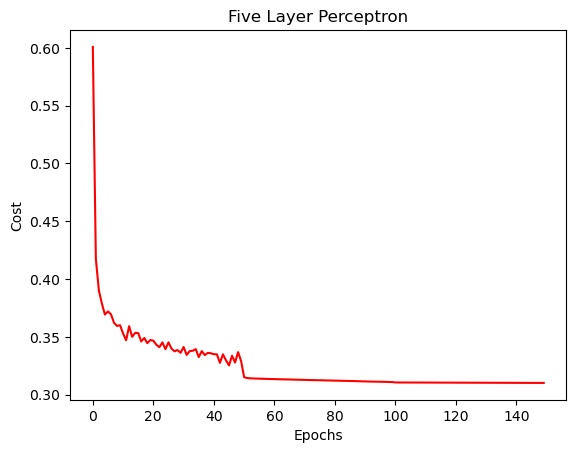

In [68]:
cost_avgs = [np.mean(x) for x in neural_network_8.cost_]

plt.plot(range(len(cost_avgs)), cost_avgs, color='red')
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.title('Five Layer Perceptron')
plt.show()